In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize
import random

## General classes

In [2]:
class Environment:
    def __init__(self):
        pass

    def round(self, product_price):
        pass

In [3]:
class Agent:
    def __init__(self):
        pass

    def pull_arm(self):
        pass

    def update(self, reward_t):
        pass

### Requirement 1: single product and stochastic environment

#### Environment

In [ ]:
class SingleProductEnvironment(Environment):
  def __init__(self, T, valuation_distr=stats.uniform):
    self.T = T # Number of rounds
    self.t = 0 # Starting round

    # Valuation of each buyer sampled from the given distribution function
    self.valuation = valuation_distr.rvs(size=T)

  def round(self, p_t):
    # Check if the buyer valuation is higher than product price
    r_t = p_t if self.valuation[self.t] >= p_t else 0

    # Update round
    self.t = self.t + 1

    return r_t

#### Agent without inventory constraint - UCB1

In [ ]:
class UCB1(Agent):
    def __init__(self, T, prices, range=1):
        self.range = range # Range of the reward
        self.P = len(prices) # Prices' set cardinality
        self.T = T # Number of rounds
        self.pi_t = None # Init price

        self.average_rewards = np.zeros(self.P)
        self.N_pulls = np.zeros(self.P)

        self.t = 0 # Starting round

    def pull_arm(self):
        # Check if the round is less then number of prices
        if self.t < self.P:
            # then set it as product_price
            self.pi_t = self.t
        else:
            # Compute UCB1
            ucbs = self.average_rewards + self.range * np.sqrt(2 * np.log(self.T)/self.N_pulls)

            # Extract the price that maximizes the UCB1
            self.pi_t = np.argmax(ucbs)

        return self.pi_t

    def update(self, reward):
        self.N_pulls[self.pi_t] += 1

        # As average, we have (total purchasing) / (number of times of purchasing)
        self.average_rewards[self.pi_t] += (reward - self.average_rewards[self.pi_t])/self.N_pulls[self.pi_t]
        self.t += 1

#### Clairvoyant without inventory constraint

In [ ]:
class SingleProductStochasticClairvoyant:
    def __init__(self, T, prices, valuation_distr=stats.uniform):
        self.T = T
        self.prices = prices

        # This is probability distributions over valuations (scipy.stats)
        self.valuation_distr = valuation_distr

    def run(self):
        # Probability of selling a product
        selling_prob = 1 - self.valuation_distr.cdf(self.prices)

        ## Liner programming
        c = - self.prices * selling_prob # objective function coefficients

        # Constraints
        A_eq = [np.ones(len(self.prices))]
        b_eq = [1]

        # Resolve LP
        res = optimize.linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=(0, 1))
        expected_utility = np.array([-res.fun for _ in range(self.T)])

        return expected_utility

#### Evaluation

In [ ]:
# Parameters
T = 10000

# Prices
max_price = 1
price_step = T ** (-1/3)
prices = np.arange(0, max_price, price_step)

# Valuation prob. distribution
max_valuation = 1
#valuation_distr = stats.binom(loc=0, n=max_valuation, p=0.5)
valuation_distr = stats.uniform(loc=0, scale=max_price)

In [ ]:
# Run clairvoyant
clairvoyant = SingleProductStochasticClairvoyant(T, prices, valuation_distr)
expected_clairvoyant_utilities = clairvoyant.run()

n_trials = 10
regret_per_trial = []
for trial in range(n_trials):

  # Define environment and agent
  env = SingleProductEnvironment(T, valuation_distr)
  ucb_like_agent = UCB1(T, prices, range=max_price)

  agent_rewards = []

  for t in range(T):
    # This returns the price index
    pi_t = ucb_like_agent.pull_arm()

    # Get the actual price
    p_t = prices[pi_t]

    # Get reward
    r_t = env.round(p_t)

    # Update agent state
    ucb_like_agent.update(r_t)

    agent_rewards.append(r_t)

  agent_rewards = np.array(agent_rewards)
  cumulative_regret = np.cumsum(expected_clairvoyant_utilities - agent_rewards)

  regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

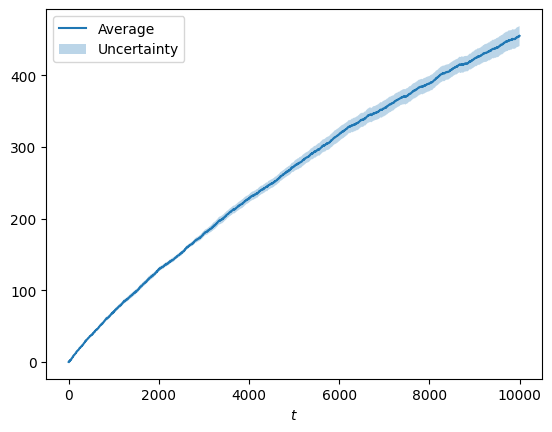

In [ ]:
average_regret = regret_per_trial.mean(axis=0) # mean
regret_sd = regret_per_trial.std(axis=0) # standard deviation

plt.plot(np.arange(T), average_regret, label="Average")
plt.fill_between(
    np.arange(T),
    average_regret-regret_sd/np.sqrt(n_trials),
    average_regret+regret_sd/np.sqrt(n_trials),
    alpha=0.3,
    label="Uncertainty"
)
plt.xlabel("$t$")
plt.legend()

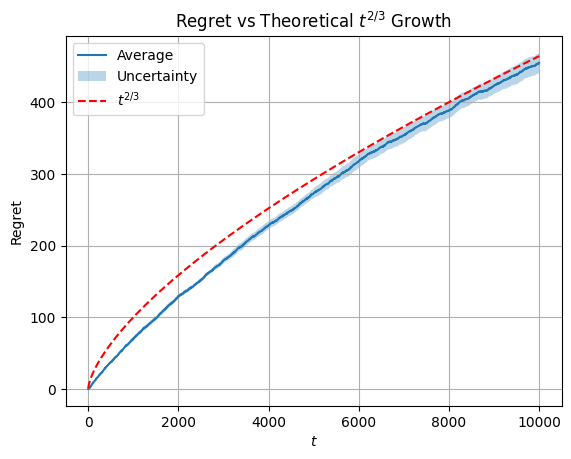

In [ ]:
average_regret = regret_per_trial.mean(axis=0)  # media
regret_sd = regret_per_trial.std(axis=0)        # deviazione standard

t = np.arange(1, T+1)  # inizia da 1 per evitare t^{2/3} = 0^{2/3} = 0
regret_theory = t**(2/3)

plt.plot(t, average_regret, label="Average")
plt.fill_between(
    t,
    average_regret - regret_sd / np.sqrt(n_trials),
    average_regret + regret_sd / np.sqrt(n_trials),
    alpha=0.3,
    label="Uncertainty"
)
plt.plot(t, regret_theory, label=r"$t^{2/3}$", linestyle='--', color='red')

plt.xlabel("$t$")
plt.ylabel("Regret")
plt.legend()
plt.title("Regret vs Theoretical $t^{2/3}$ Growth")
plt.grid(True)
plt.show()

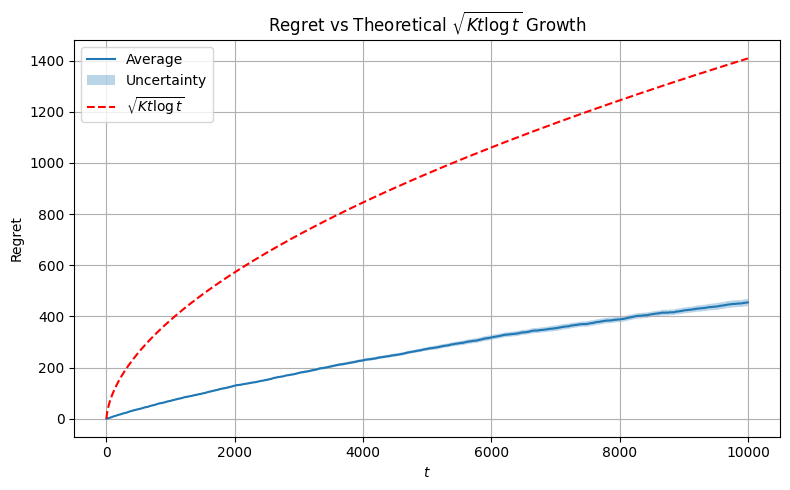

In [ ]:
K= 1/price_step
t = np.arange(1, T + 1)  # da 1 per evitare log(0)
theoretical_curve = np.sqrt(K * t * np.log(t))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(np.arange(T), average_regret, label="Average")
plt.fill_between(
    np.arange(T),
    average_regret - regret_sd / np.sqrt(n_trials),
    average_regret + regret_sd / np.sqrt(n_trials),
    alpha=0.3,
    label="Uncertainty"
)

# Aggiunta curva asintotica
plt.plot(t - 1, theoretical_curve, label=r"$\sqrt{K t \log t}$", linestyle="--", color="red")

plt.xlabel("$t$")
plt.ylabel("Regret")
plt.title("Regret vs Theoretical $\sqrt{K t \log t}$ Growth")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Agent with inventory constraint - UCB-like

In [ ]:
class UCBLike():
    def __init__(self, T, B, prices, range=1):
        self.T = T
        self.P = len(prices)
        self.range = range

        self.pi_t = None
        self.avg_f = np.zeros(self.P)
        self.avg_c = np.zeros(self.P)
        self.N_pulls = np.zeros(self.P)
        self.budget = B

        self.t = 0

    def pull_arm(self):
        # Check if budget is depleted
        if self.budget < 1:
            self.pi_t = 0
            return 0

        if self.t < self.P:
            self.pi_t = self.t
        else:
            # Upper Confidence Bound
            f_ucbs = self.avg_f + self.range * np.sqrt( 2 * np.log(self.T)/self.N_pulls)

            # Lower Confidence Bound
            c_lcbs = self.avg_c - self.range * np.sqrt( 2 * np.log(self.T)/self.N_pulls)

            # Price optimal distribution
            gamma_t = self.compute_opt(f_ucbs, c_lcbs)

            # Set current price
            self.pi_t = np.random.choice(self.P, p=gamma_t)

        return self.pi_t

    def compute_opt(self, f_ucbs, c_lcbs):
        if np.sum(c_lcbs <= np.zeros(len(c_lcbs))):
            gamma = np.zeros(len(f_ucbs))
            gamma[np.argmax(f_ucbs)] = 1
            return gamma

        c = -f_ucbs

        A_ub = [c_lcbs]
        rho = self.budget/self.T
        b_ub = [rho]

        A_eq = [np.ones(self.P)]
        b_eq = [1]

        res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))

        gamma = res.x
        return gamma

    def update(self, f_t, c_t):
        # Update the number of pulled price
        self.N_pulls[self.pi_t] += 1

        # Update averages
        self.avg_f[self.pi_t] = self.avg_f[self.pi_t] + (f_t - self.avg_f[self.pi_t])/self.N_pulls[self.pi_t]
        self.avg_c[self.pi_t] = self.avg_c[self.pi_t] + (c_t - self.avg_c[self.pi_t])/self.N_pulls[self.pi_t]

        # Update budget
        self.budget = self.budget - c_t

        self.t += 1

#### Clairvoyant with inventory constraint

In [ ]:
class SingleProductStochasticInventoryClaivoyant:
    def __init__(self, T, budget, prices, valuation_distr=stats.uniform):
        self.T = T
        self.prices = prices
        self.budget = budget

        # This is probability distributions over valuations (scipy.stats)
        self.valuation_distr = valuation_distr

    def run(self):
        # Probability of selling a product
        selling_prob = 1 - self.valuation_distr.cdf(self.prices)

        ## Liner programming
        c = - self.prices * selling_prob # objective function coefficients

        # Constraints
        A_eq = [np.ones(len(self.prices))]
        b_eq = [1]

        A_ub = [selling_prob]
        rho = self.budget/self.T
        b_ub = [rho]

        # Resolve LP
        res = optimize.linprog(c, A_eq=A_eq, b_eq=b_eq, A_ub=A_ub, b_ub=b_ub, bounds=(0, 1))
        expected_utility = np.array([-res.fun for _ in range(self.T)])

        return expected_utility

#### Evaluation

In [ ]:
# Parameters
T = 10000
B = T * 3/4

# Prices
max_price = 1
price_step = 0.2
prices = np.arange(0, max_price, price_step)

# Valuation prob. distribution
max_valuation = 1
valuation_distr = stats.uniform(loc=0, scale=max_price)

In [ ]:
# Run clairvoyant
clairvoyant = SingleProductStochasticInventoryClaivoyant(T, B, prices, valuation_distr)

expected_clairvoyant_utilities = clairvoyant.run()

n_trials = 20
regret_per_trial = []
for trial in range(n_trials):

  # Define environment and agent
  env = SingleProductEnvironment(T)
  ucb_like_agent = UCBLike(T, B, prices, range=max_price)

  agent_rewards = []
  for t in range(T):
    if(B<=0):
      break
    # This returns the price index
    pi_t = ucb_like_agent.pull_arm()

    # Get the actual price
    p_t = prices[pi_t]

    # Get reward
    r_t = env.round(p_t)

    # Update agent state
    ucb_like_agent.update(r_t, r_t > 0)

    agent_rewards.append(r_t)
    if(r_t>0):
      B = B - 1

  agent_rewards = np.array(agent_rewards)
  cumulative_regret = np.cumsum(expected_clairvoyant_utilities - agent_rewards)
  regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

ValueError: operands could not be broadcast together with shapes (10000,) (5508,) 

In [ ]:
average_regret = regret_per_trial.mean(axis=0) # mean
regret_sd = regret_per_trial.std(axis=0) # standard deviation

plt.plot(np.arange(T), average_regret, label="Average")
plt.fill_between(
    np.arange(T),
    average_regret-regret_sd/np.sqrt(n_trials),
    average_regret+regret_sd/np.sqrt(n_trials),
    alpha=0.3,
    label="Uncertainty"
)
plt.xlabel("$t$")
plt.legend()

In [ ]:
ucb_like_agent.budget

In [ ]:
t = np.arange(1, T + 1)  # da 1 per evitare log(0)
theoretical_curve = np.sqrt(t)
average_regret = regret_per_trial.mean(axis=0) # mean
regret_sd = regret_per_trial.std(axis=0) # standard deviation

plt.plot(np.arange(T), average_regret, label="Average")
plt.fill_between(
    np.arange(T),
    average_regret-regret_sd/np.sqrt(n_trials),
    average_regret+regret_sd/np.sqrt(n_trials),
    alpha=0.3,
    label="Uncertainty"
)


plt.plot(t - 1, theoretical_curve, label=r"$\sqrt{t }$", linestyle="--", color="red")


plt.xlabel("$t$")
plt.ylabel("Regret")
plt.title("Regret vs Theoretical $\sqrt{ t}$ Growth")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Requirement 2: multiple products and stochastic environment

In [ ]:
class MultipleProductEnvironment(Environment):
  def __init__(self, T, N, max_valuation):
    self.T = T # Number of buyers (rounds)
    self.N = N # Number of types of products
    self.t = 0 # Current buyer

    # Valuation of each buyer sampled from the given distribution function
    self.valuations = np.random.uniform(0, max_valuation, size=(T, N))

  def round(self, p_t):
    reward = np.array([])

    # Check if the buyer valuations are higher than products prices
    for valuation, price in zip(self.valuations[self.t, :], p_t):
      if valuation >= price:
        reward = np.append(reward, price)
      else:
        reward = np.append(reward, 0.)

    # Update round
    self.t = self.t + 1
    return reward

### Requirement 3: best-of-both-worlds algorithms with a single product

In [91]:
def getDistribution():
    arr = np.arange(0.2, 2, 0.2)
    random_index_a = random.randint(0, len(arr) - 1)
    random_index_b = random.randint(0, len(arr) - 1)

    return stats.beta(arr[random_index_a], arr[random_index_b])

In [4]:
def getDistribution():
    a = stats.uniform(loc=0, scale=2).rvs()
    b = stats.uniform(loc=0, scale=2).rvs()

    return stats.beta(a,b)

In [60]:
def getDistribution():
    arr = np.arange(2, 8, 1)  # valori tra 2 e 7
    a = np.random.choice(arr)
    b = np.random.choice(arr)
    return stats.beta(a, b)

#### Environment

In [92]:
class SingleProductHighlyNonStationaryEnvironment(Environment):
  def __init__(self, T, valuation_distr):
    self.T = T # Number of rounds
    self.t = 0 # Starting round

    # Valuation of each buyer sampled from the given distribution function
    #self.valuation = valuation_distr.rvs(size=T)
    self.valuation = [valuation_distr[i].rvs() for i in range(T)]

  def round(self, p_t):
    # Check if the buyer valuation is higher than product price
    r_t = p_t if self.valuation[self.t] >= p_t else 0

    # Update round
    self.t = self.t + 1

    return r_t

#### Clairvoyant

In [93]:
class SingleProductHighltyNonStationaryClairvoyant:
    def __init__(self, T, B, prices, valuation_distr):
        self.T = T
        self.prices = prices
        self.B=B
        # This is probability distributions over valuations (scipy.stats)
        self.valuation_distr = valuation_distr

    def run(self):
        # Probability of selling a product

        selling_prob = [1 - self.valuation_distr[i].cdf(self.prices) for i in range(T)]
        selling_prob_mean=np.mean(selling_prob, axis=0)

        ## Liner programming
        c = - self.prices * selling_prob_mean # objective function coefficients

        # Constraints
        A_eq = [np.ones(len(self.prices))]
        b_eq = [1]

        A_ub = [selling_prob_mean]
        rho=self.B/self.T
        b_ub = [rho]

        # Resolve LP
        res = optimize.linprog(c, A_eq=A_eq, b_eq=b_eq, A_ub=A_ub, b_ub=b_ub, bounds=(0,1))
        expected_utility = np.array([-res.fun for _ in range(self.T)])

        return expected_utility

#### Agent

In [94]:
class EXP3Agent(Agent):
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.a_t = None
        self.x_t = np.ones(K)/K
        self.N_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t

    def update(self, l_t):
        l_t_tilde = l_t/self.x_t[self.a_t]
        self.weights[self.a_t] *= np.exp(-self.learning_rate*l_t_tilde)
        self.N_pulls[self.a_t] += 1
        self.t += 1

In [122]:
class FFMultiplicativePacingAgent(Agent):
    def __init__(self, prices_set, budget, T, eta, learning_rate):
        self.prices_set = prices_set
        self.K = len(prices_set)
        self.learning_rate = learning_rate
        self.exp3 = EXP3Agent(self.K, self.learning_rate)
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0
        self.N_pulls = np.zeros(len(prices_set))
        self.price_index = 0
        self._lambdas = []

    def pull_arm(self):
        if self.budget < 1:
            #self.price_index = 0
            return 1.1

       # epsilon = 0.1  # 10% round di esplorazione
       # low_price_idxs = [i for i, p in enumerate(self.prices_set) if p <= 0.4]

       # if np.random.rand() < epsilon:
       #     self.price_index = np.random.choice(low_price_idxs)
       # else:
       #     self.price_index = self.exp3.pull_arm()

        self.price_index = self.exp3.pull_arm()
        return self.prices_set[self.price_index]

    def update(self, f_t):
        self.rho = self.budget/(self.T-self.t+1)
        c_t = int(f_t > 0) # >=
        L = f_t - self.lmbd*(c_t-self.rho)



# rescale lineare tra min e max possibili
        # L_rescaled = (L + self.lmbd) / (max(self.prices_set) + self.lmbd + 1e-12)
        # self.exp3.update(1-L_rescaled)

        L_up = 1 -(1/self.rho)*(-self.rho)
        L_low = 0 -(1/self.rho)*(1-self.rho)
        rescaled_L = (L - L_low)/(L_up-L_low)
        self.exp3.update(1 -rescaled_L) # we need to maximize L

        # update lagrangian multiplier
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t),
                            a_min=0, a_max=1/self.rho)

        self._lambdas.append((self.lmbd, c_t))

        # update budget
        self.budget -= c_t
        # log
        self.N_pulls[self.price_index] += 1

    def get_budget(self):
      return self.budget

    def lambdas(self):
      return self._lambdas

#### Prove agent

In [ ]:
class EXP3PAgent(Agent):
    def __init__(self, K, T, alpha, gamma):
        self.K = K                      # Numero di bracci
        self.T = T                      # Orizzonte
        self.alpha = alpha              # Parametro α > 0
        self.gamma = gamma              # Parametro γ ∈ (0,1]

        # Inizializzazione dei pesi
        init_weight = np.exp((alpha * gamma / 3) * np.sqrt(T / K))
        self.weights = np.full(K, init_weight)

        self.t = 0                      # Tempo
        self.x_t = np.ones(K) / K      # Distribuzione iniziale
        self.a_t = None                # Azione scelta

    def pull_arm(self):
        # Passo 1: Calcolo delle probabilità p_i(t)
        weight_sum = np.sum(self.weights)
        self.x_t = (1 - self.gamma) * (self.weights / weight_sum) + self.gamma / self.K

        # Passo 2: Seleziona l'azione
        self.a_t = np.random.choice(self.K, p=self.x_t)
        return self.a_t

    def update(self, reward):
        # Passo 3: reward osservato ∈ [0,1]
        # Passo 4: Stima del reward (importance-weighted)
        estimated_reward = np.zeros(self.K)
        estimated_reward[self.a_t] = reward / self.x_t[self.a_t]

        # Passo 5: Aggiornamento dei pesi
        for j in range(self.K):
            bonus = self.alpha / self.x_t[j] * np.sqrt(self.K / self.T)
            exponent = (self.gamma / (3 * self.K)) * (estimated_reward[j] + bonus)
            self.weights[j] *= np.exp(exponent)

        self.t += 1

In [ ]:
import numpy as np

class EXP3P_Bandit_Agent(Agent):
    def __init__(self, N, eta, alpha, gamma):
        self.N = N                  # Numero di azioni (bracci)
        self.alpha = alpha            # Stabilizzazione
        self.eta = eta              # Learning rate
        self.gamma = gamma          # Esplorazione
        self.weights = np.ones(N)   # Pesi iniziali
        self.p = np.ones(N) / N     # Distribuzione iniziale
        self.last_action = None
        self.t = 0

    def pull_arm(self):
        self.last_action = np.random.choice(self.N, p=self.p)
        return self.last_action

    def update(self, observed_reward):
        i = self.last_action
        g_tilde = np.zeros(self.N)

        # Solo il braccio selezionato riceve reward stimato
        g_tilde[i] = (observed_reward + self.alpha) / self.p[i]

        # Gli altri ricevono solo bonus β / p_i
        for j in range(self.N):
            if j != i:
                g_tilde[j] = self.alpha / self.p[j]

        # Aggiorna pesi
        self.weights *= np.exp(self.eta * g_tilde)

        # Ricalcola distribuzione con smoothing
        W_t = np.sum(self.weights)
        self.p = (1 - self.gamma) * (self.weights / W_t) + self.gamma / self.N

        self.t += 1


In [ ]:
delta = 0.05
alpha = np.sqrt( (1 / (T * K)) * np.log(K / delta) )
gamma = (4 * K * alpha) / (3 + alpha)
eta = gamma / (2 * K)

#### Parameters

In [112]:
# Parameters
T = 100000
B = T * 3/4

# Prices
max_price = 1.1
price_step = 0.1
prices = np.arange(0.1, max_price, price_step)
K = len(prices)
# Valuation prob. distribution
max_valuation = 1

In [34]:
prices

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [35]:
K

10

In [113]:
learning_rate = np.sqrt(np.log(K)/(K*T))  #learning rate EXP3
eta=1/np.sqrt(T)   #learing rate Multiplicative pacing

TIME_INTERVAL = 1    #interval in which the distribution remain the same
valuation_distributions = []
for t in range(T):
  if t % TIME_INTERVAL == 0:
    distr = getDistribution()

  valuation_distributions.append(distr)

# selling_prob = [1 - valuation_distributions[i].cdf(prices) for i in range(T)]
# selling_prob_mean=np.mean(selling_prob, axis=0)

In [28]:
sample_vals = [valuation_distributions[t].rvs() for t in range(T)]
print(f"Valore medio sample: {np.mean(sample_vals):.3f}")
print(f"Valore minimo sample: {np.min(sample_vals):.3f}")
print(f"Valore massimo sample: {np.max(sample_vals):.3f}")

Valore medio sample: 0.503
Valore minimo sample: 0.005
Valore massimo sample: 0.999


In [114]:
from collections import Counter

# Calcola media e varianza per ogni distribuzione
mean_var_pairs = []

for dist in valuation_distributions:
    mean, var = dist.stats(moments='mv')
    mean = float(np.round(mean, 4))  # arrotondo per evitare problemi di float
    var = float(np.round(var, 4))
    mean_var_pairs.append((mean, var))

# Conta quante volte appaiono le coppie (mean, var)
count_mv = Counter(mean_var_pairs)

# Stampa solo quelle diverse (una volta ciascuna, con frequenza)
print("Distribuzioni distinte (media, varianza) e frequenze:")
for (mean, var), count in sorted(count_mv.items()):
    print(f"mean={mean:.4f}, var={var:.4f} → {count} volte")

means = [m for m, v in mean_var_pairs]

print(f"Valore medio sample: {np.mean(means):.3f}")
print(f"Valore minimo sample: {np.min(means):.3f}")
print(f"Valore massimo sample: {np.max(means):.3f}")

Distribuzioni distinte (media, varianza) e frequenze:
mean=0.1000, var=0.0300 → 1222 volte
mean=0.1111, var=0.0353 → 1228 volte
mean=0.1250, var=0.0421 → 1188 volte
mean=0.1429, var=0.0510 → 1279 volte
mean=0.1667, var=0.0631 → 1254 volte
mean=0.1818, var=0.0465 → 1271 volte
mean=0.2000, var=0.0533 → 1210 volte
mean=0.2000, var=0.0800 → 1150 volte
mean=0.2222, var=0.0617 → 1292 volte
mean=0.2500, var=0.0551 → 1228 volte
mean=0.2500, var=0.0721 → 1212 volte
mean=0.2500, var=0.1042 → 1196 volte
mean=0.2727, var=0.0620 → 1119 volte
mean=0.2857, var=0.0850 → 1203 volte
mean=0.3000, var=0.0700 → 1231 volte
mean=0.3077, var=0.0592 → 1261 volte
mean=0.3333, var=0.0654 → 1264 volte
mean=0.3333, var=0.0794 → 1195 volte
mean=0.3333, var=0.1010 → 1194 volte
mean=0.3333, var=0.1389 → 1179 volte
mean=0.3571, var=0.0604 → 1239 volte
mean=0.3636, var=0.0723 → 1224 volte
mean=0.3750, var=0.0901 → 1231 volte
mean=0.3846, var=0.0657 → 1211 volte
mean=0.4000, var=0.0600 → 1274 volte
mean=0.4000, var=0.08

In [118]:
#print of the distributions (only the different values)

means = []
vars_ = []

for i, dist in enumerate(valuation_distributions):
    mean, var = dist.stats(moments='mv')
    means.append(mean)
    vars_.append(var)
printed = set()
for i, (m, v) in enumerate(zip(means, vars_)):
    key = (round(float(m), 6), round(float(v), 6))  # Arrotonda per evitare problemi di floating point
    if key not in printed:
        print(f"Distribuzione {i}: mean = {m:.3f}, var = {v:.3f}")
        printed.add(key)

Distribuzione 0: mean = 0.636, var = 0.019
Distribuzione 1: mean = 0.286, var = 0.026
Distribuzione 2: mean = 0.667, var = 0.022
Distribuzione 3: mean = 0.700, var = 0.019
Distribuzione 4: mean = 0.462, var = 0.018
Distribuzione 6: mean = 0.500, var = 0.023
Distribuzione 7: mean = 0.571, var = 0.031
Distribuzione 9: mean = 0.444, var = 0.025
Distribuzione 10: mean = 0.455, var = 0.021
Distribuzione 11: mean = 0.545, var = 0.021
Distribuzione 13: mean = 0.750, var = 0.021
Distribuzione 15: mean = 0.600, var = 0.040
Distribuzione 16: mean = 0.429, var = 0.031
Distribuzione 17: mean = 0.364, var = 0.019
Distribuzione 19: mean = 0.556, var = 0.025
Distribuzione 20: mean = 0.375, var = 0.026
Distribuzione 21: mean = 0.222, var = 0.017
Distribuzione 22: mean = 0.600, var = 0.022
Distribuzione 24: mean = 0.778, var = 0.017
Distribuzione 25: mean = 0.714, var = 0.026
Distribuzione 26: mean = 0.538, var = 0.018
Distribuzione 28: mean = 0.500, var = 0.036
Distribuzione 30: mean = 0.333, var = 0.

In [115]:
prices_arr = []
rewards = []

residual_budget = []

# Run clairvoyant
clairvoyant = SingleProductHighltyNonStationaryClairvoyant(T, B, prices, valuation_distributions)
expected_clairvoyant_utilities = clairvoyant.run()

n_trials = 1
regret_per_trial = []
for trial in range(n_trials):

  # Define environment and agent
  env = SingleProductHighlyNonStationaryEnvironment(T, valuation_distributions)
  multiplicative_pacing_agent = FFMultiplicativePacingAgent(prices, B, T, eta, learning_rate)
  count = 0
  agent_rewards = []
  for t in range(T):
    if(count>=B):
      r_t = 0
      agent_rewards.append(r_t)
    else:
      # This returns the price index
      #pi_t = multiplicative_pacing_agent.pull_arm()
      # Get the actual price
      p_t = multiplicative_pacing_agent.pull_arm()
      # Get reward
      r_t = env.round(p_t)

      prices_arr.append(p_t)
      rewards.append(r_t)

      # Update agent state
      multiplicative_pacing_agent.update(r_t)

      agent_rewards.append(r_t)
      if(r_t > 0):
        count = count + 1

  agent_rewards = np.array(agent_rewards)
  cumulative_regret = np.cumsum(expected_clairvoyant_utilities - agent_rewards)
  regret_per_trial.append(cumulative_regret)

  residual_budget.append(multiplicative_pacing_agent.get_budget())

regret_per_trial = np.array(regret_per_trial)

In [116]:
from collections import Counter

price_counts = Counter(prices_arr)

print("Frequenze dei prezzi scelti:")
for price in sorted(price_counts):
    print(f"Prezzo {price:.2f}: scelto {price_counts[price]} volte")

Frequenze dei prezzi scelti:
Prezzo 0.10: scelto 3459 volte
Prezzo 0.20: scelto 4272 volte
Prezzo 0.30: scelto 6668 volte
Prezzo 0.40: scelto 14133 volte
Prezzo 0.50: scelto 6640 volte
Prezzo 0.60: scelto 28555 volte
Prezzo 0.70: scelto 12317 volte
Prezzo 0.80: scelto 14072 volte
Prezzo 0.90: scelto 6575 volte
Prezzo 1.00: scelto 3309 volte


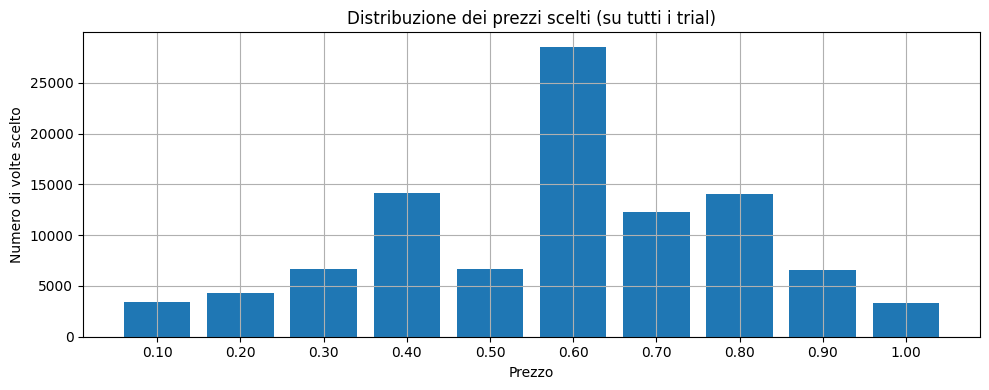

In [117]:
import matplotlib.pyplot as plt

# Ordina per prezzo crescente
sorted_prices = sorted(price_counts)
counts = [price_counts[p] for p in sorted_prices]

plt.figure(figsize=(10, 4))
plt.bar([f"{p:.2f}" for p in sorted_prices], counts)
plt.xlabel("Prezzo")
plt.ylabel("Numero di volte scelto")
plt.title("Distribuzione dei prezzi scelti (su tutti i trial)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [105]:
prices_arr[:50]

[np.float64(0.4),
 np.float64(0.5),
 np.float64(1.0),
 np.float64(0.7000000000000001),
 np.float64(0.6),
 np.float64(1.0),
 np.float64(0.4),
 np.float64(0.4),
 np.float64(0.4),
 np.float64(0.4),
 np.float64(0.5),
 np.float64(0.5),
 np.float64(0.4),
 np.float64(0.1),
 np.float64(0.2),
 np.float64(0.4),
 np.float64(0.1),
 np.float64(0.5),
 np.float64(0.2),
 np.float64(0.7000000000000001),
 np.float64(0.2),
 np.float64(0.4),
 np.float64(0.5),
 np.float64(0.2),
 np.float64(0.9),
 np.float64(1.0),
 np.float64(0.4),
 np.float64(0.9),
 np.float64(0.1),
 np.float64(0.9),
 np.float64(1.0),
 np.float64(0.6),
 np.float64(0.5),
 np.float64(0.6),
 np.float64(0.30000000000000004),
 np.float64(0.30000000000000004),
 np.float64(0.6),
 np.float64(0.1),
 np.float64(0.30000000000000004),
 np.float64(0.1),
 np.float64(0.9),
 np.float64(0.8),
 np.float64(0.4),
 np.float64(0.7000000000000001),
 np.float64(0.2),
 np.float64(0.6),
 np.float64(0.30000000000000004),
 np.float64(1.0),
 np.float64(0.9),
 np.float

In [106]:
prices_arr[-50 : ]

[np.float64(0.6),
 np.float64(0.8),
 np.float64(0.4),
 np.float64(0.7000000000000001),
 np.float64(0.5),
 np.float64(0.8),
 np.float64(0.6),
 np.float64(0.7000000000000001),
 np.float64(0.8),
 np.float64(0.9),
 np.float64(0.8),
 np.float64(0.7000000000000001),
 np.float64(0.6),
 np.float64(0.8),
 np.float64(0.7000000000000001),
 np.float64(1.0),
 np.float64(0.7000000000000001),
 np.float64(0.8),
 np.float64(0.7000000000000001),
 np.float64(0.9),
 np.float64(0.9),
 np.float64(0.5),
 np.float64(0.7000000000000001),
 np.float64(0.8),
 np.float64(0.8),
 np.float64(0.7000000000000001),
 np.float64(0.7000000000000001),
 np.float64(0.8),
 np.float64(0.9),
 np.float64(0.7000000000000001),
 np.float64(0.9),
 np.float64(0.5),
 np.float64(0.7000000000000001),
 np.float64(0.8),
 np.float64(0.9),
 np.float64(0.8),
 np.float64(0.6),
 np.float64(0.8),
 np.float64(0.7000000000000001),
 np.float64(0.7000000000000001),
 np.float64(0.8),
 np.float64(0.8),
 np.float64(0.7000000000000001),
 np.float64(0.8)

In [41]:
set(prices_arr)

{np.float64(0.1),
 np.float64(0.2),
 np.float64(0.30000000000000004),
 np.float64(0.4),
 np.float64(0.5),
 np.float64(0.6),
 np.float64(0.7000000000000001),
 np.float64(0.8),
 np.float64(0.9),
 np.float64(1.0)}

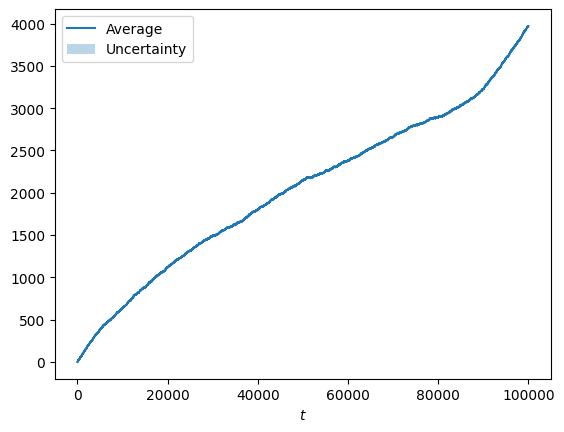

In [118]:
average_regret = regret_per_trial.mean(axis=0) # mean
regret_sd = regret_per_trial.std(axis=0) # standard deviation

plt.plot(np.arange(T), average_regret, label="Average")
plt.fill_between(
    np.arange(T),
    average_regret-regret_sd/np.sqrt(n_trials),
    average_regret+regret_sd/np.sqrt(n_trials),
    alpha=0.3,
    label="Uncertainty"
)
plt.xlabel("$t$")
plt.legend()

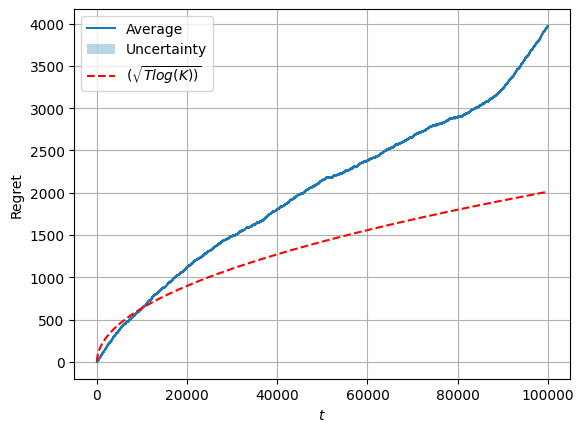

In [119]:
average_regret = regret_per_trial.mean(axis=0)  # media
regret_sd = regret_per_trial.std(axis=0)        # deviazione standard

t = np.arange(1, T+1)  # inizia da 1 per evitare t^{2/3} = 0^{2/3} = 0
regret_theory = (900 / np.sqrt(20000*np.log(K))) * np.sqrt(t*np.log(K))

plt.plot(t, average_regret, label="Average")
plt.fill_between(
    t,
    average_regret - regret_sd / np.sqrt(n_trials),
    average_regret + regret_sd / np.sqrt(n_trials),
    alpha=0.3,
    label="Uncertainty"
)
plt.plot(t, regret_theory, label=r"$(\sqrt{Tlog(K))}$", linestyle='--', color='red')

plt.xlabel("$t$")
plt.ylabel("Regret")
plt.legend()
plt.grid(True)
plt.show()

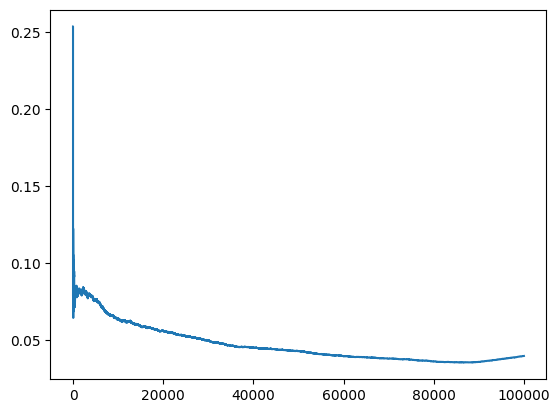

In [120]:
diff = average_regret / t
plt.plot(t, diff, label="andament")

In [45]:
np.array(residual_budget)

array([3138., 3189., 2927., 3134., 3115., 3175., 3062., 2991., 3137.,
       2942.])

In [121]:
residual_budget_mean = np.array(residual_budget).mean()
print(np.sqrt(np.var(residual_budget)))
print(residual_budget_mean)

print(residual_budget_mean / B)

0.0
32003.0
0.4267066666666667


In [47]:
multiplicative_pacing_agent.lambdas()

[(np.float64(0.9925007499250075), 0),
 (np.float64(0.985001499850015), 0),
 (np.float64(0.9775022497750224), 0),
 (np.float64(0.9800029997000299), 1),
 (np.float64(0.9825047495250474), 1),
 (np.float64(0.9850074992500749), 1),
 (np.float64(0.9775112488751124), 0),
 (np.float64(0.98001499850015), 1),
 (np.float64(0.9825197480251975), 1),
 (np.float64(0.975025497450255), 0),
 (np.float64(0.9675312468753126), 0),
 (np.float64(0.9700369963003701), 1),
 (np.float64(0.9625437456254375), 0),
 (np.float64(0.965050494950505), 1),
 (np.float64(0.9575582441755824), 0),
 (np.float64(0.9500659934006599), 0),
 (np.float64(0.9425737426257373), 0),
 (np.float64(0.9350814918508148), 0),
 (np.float64(0.9375892410758923), 1),
 (np.float64(0.9300979902009797), 0),
 (np.float64(0.9226067393260672), 0),
 (np.float64(0.9251154884511547), 1),
 (np.float64(0.9276252374762521), 1),
 (np.float64(0.9301359864013596), 1),
 (np.float64(0.9326477352264771), 1),
 (np.float64(0.9251604839516047), 0),
 (np.float64(0.91

### Requirement 4: best-of-both-worlds algorithms with multiple products

### Requirement 5: slightly non-stationary environments with multiple products